In [1]:
import torch

from model.GCN_classifier import TimeDiffClassifier
from model.GCN_classifier import TimeDiffClassifier_sagpooling

import pytorch_lightning as pl

import os.path as osp
import matplotlib.pyplot as plt


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
hparams = {}
hparams['batch_size'] = 32
hparams['num_classes'] = 2
hparams['hidden_channels'] = 64
#hparams['num_node_features'] = 149
hparams['batch_size'] = 32
hparams['lr'] = 1.0e-03
hparams['weight_decay'] = 5.0e-06

s='./data_diff'
hparams['s_data'] = osp.join(*(s.split('/')))
s='./data/DT_File_MAP.xlsx'
hparams['s_node'] = osp.join(*(s.split('/')))
s='./data/[UNC]ADNI-network/dataTS.csv'
hparams['s_date'] = osp.join(*(s.split('/')))
s = './sparsification/data'
hparams['s_sparsified'] = osp.join(*(s.split('/'))) + osp.sep


#model.prepare_data()





cpu


In [4]:
model = TimeDiffClassifier(hparams)
model = model.to(device)

trainer = None

epochs = 300

logdir = './lightning_logs'
network_logger = pl.loggers.TensorBoardLogger(
    save_dir=logdir,
    name='TimeDiffClassify_logs'
)
logger = network_logger

early_stopping = pl.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=30,
)

In [5]:
trainer = pl.Trainer(max_epochs=epochs, early_stop_callback=early_stopping)

trainer.fit(model)

GPU available: False, used: False
No environment variable for node rank defined. Set as 0.
C:\Users\rlckd\Anaconda3\envs\graph_matching\lib\site-packages\pytorch_lightning\utilities\distributed.py:23: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)

  | Name              | Type           | Params
-------------------------------------------------
0 | model             | GCN            | 22 K  
1 | model.conv1       | GCNConv        | 9 K   
2 | model.conv2       | GCNConv        | 4 K   
3 | model.conv3       | GCNConv        | 4 K   
4 | model.att         | GlobalAtt_gate | 65    
5 | model.att.gate_nn | Linear         | 65    
6 | model.lin1        | Linear         | 4 K   
7 | model.lin2        | Linear         | 130   


Number of training graphs: 103
Number of validation graphs: 12
Number of test graphs: 14


1

In [65]:
model.eval()
_, acc =  model.getTestAcc()
acc

0.7142857142857143

In [6]:
trainer.test(model)

Number of training graphs: 103
Number of validation graphs: 12
Number of test graphs: 14


--------------------------------------------------------------------------------
TEST RESULTS
{'test_acc': 0.7142857142857143, 'test_loss': tensor(0.3407)}
--------------------------------------------------------------------------------



<BarContainer object of 148 artists>

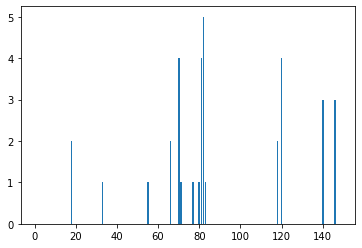

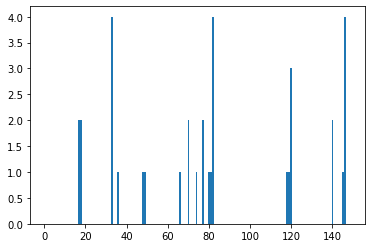

In [58]:
topk = 5
model.model.eval()
cnt_dict = []
cnt_dict.append({i+1:0 for i in range(148)})
cnt_dict.append({i+1:0 for i in range(148)})
for d  in model.dataset['test']:
    #print(d.y)
    att = model.model.get_att(x=d.x, edge_index = d.edge_index, edge_attr = d.edge_attr)
    #att.shape
    att_values = {}
    att_values = {i+1:v[0] for i,v in enumerate(att.tolist())}
    
    #att_values
    l = list({k: v for k, v in sorted(att_values.items(), key=lambda item: item[1], reverse = True)}.keys())
    for tk in l[:topk]:
        cnt_dict[d.y][tk] = cnt_dict[d.y][tk]+1
plt.figure(0)
plt.bar(cnt_dict[0].keys(),cnt_dict[0].values())
plt.figure(1)
plt.bar(cnt_dict[1].keys(),cnt_dict[1].values())

<BarContainer object of 148 artists>

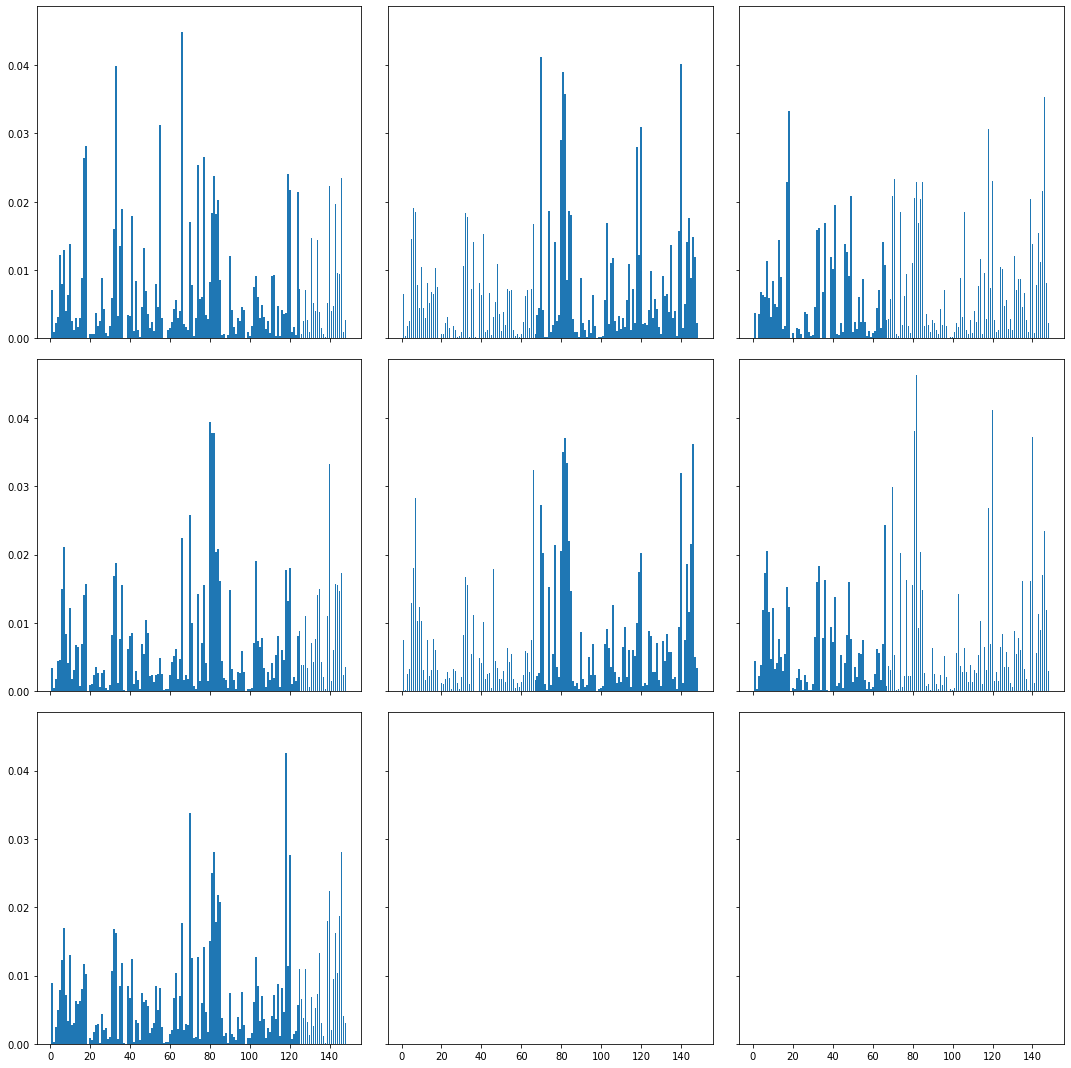

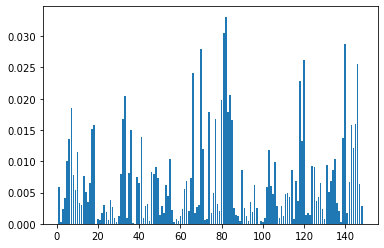

In [87]:
model.model.eval()
nrows = 3
ncols = 3
fig, axes = plt.subplots(figsize=(15, 15) , nrows = nrows, ncols = ncols, sharex='all', sharey='all')
fig.tight_layout()

cnt = 0
avg_dict0 = {i+1:0 for i in range(148)}
for tc,d  in enumerate(model.dataset['test']):
    #print(d.y)
    if(d.y == 0) :
        ax = axes[cnt//ncols][cnt%ncols]
        cnt = cnt+1
        att = model.model.get_att(x=d.x, edge_index = d.edge_index, edge_attr = d.edge_attr)
        #att.shape
        att_values = {}
        att_values = {i+1:v[0] for i,v in enumerate(att.tolist())}
        for j in range(148):
            i=j+1
            avg_dict0[i] = avg_dict0[i] + att_values[i]
        ax.bar(att_values.keys(),att_values.values())

avg_dict0 = {i+1:(avg_dict0[i+1]/cnt) for i in range(148)}
plt.figure(0)
plt.bar(avg_dict0.keys(),avg_dict0.values())

<BarContainer object of 148 artists>

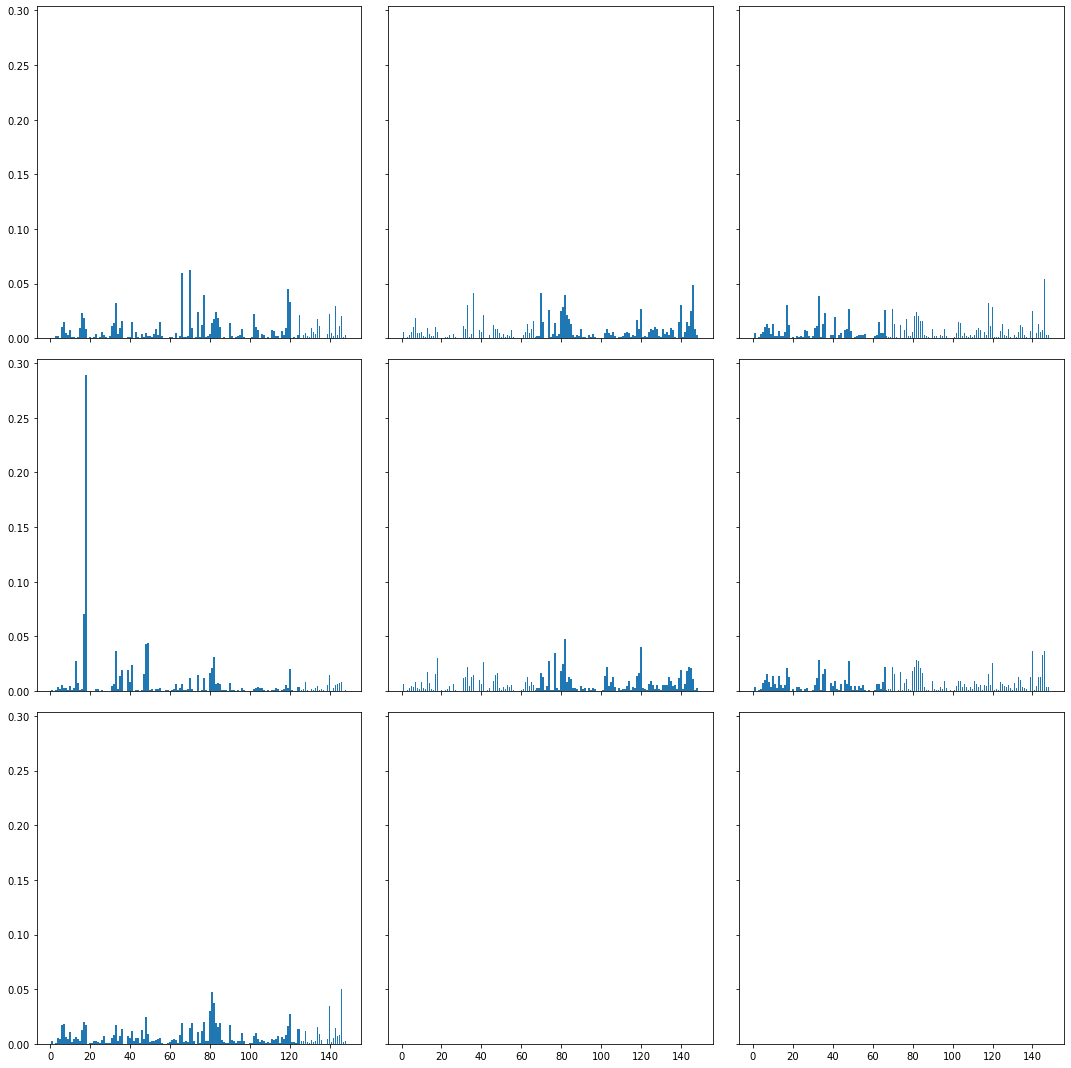

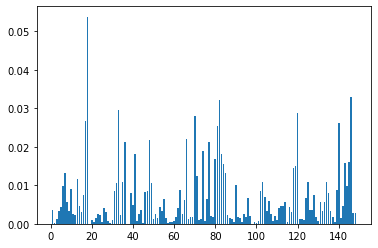

In [93]:
model.model.eval()
nrows = 3
ncols = 3
fig, axes = plt.subplots(figsize=(15, 15) , nrows = nrows, ncols = ncols, sharex='all', sharey='all')
fig.tight_layout()

cnt = 0
avg_dict1 = {i+1:0 for i in range(148)}
for tc,d  in enumerate(model.dataset['test']):
    #print(d.y)
    if(d.y == 1) :
        ax = axes[cnt//ncols][cnt%ncols]
        cnt = cnt+1
        att = model.model.get_att(x=d.x, edge_index = d.edge_index, edge_attr = d.edge_attr)
        #att.shape
        att_values = {}
        att_values = {i+1:v[0] for i,v in enumerate(att.tolist())}
        for j in range(148):
            i=j+1
            avg_dict1[i] = avg_dict1[i] + att_values[i]
        ax.bar(att_values.keys(),att_values.values())

avg_dict1 = {i+1:(avg_dict1[i+1]/cnt) for i in range(148)}
plt.figure(0)
plt.bar(avg_dict1.keys(),avg_dict1.values())

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
hparams = {}
hparams['split_train'] = 0.7
hparams['split_val'] = 0.2


hparams['batch_size'] = 32
hparams['num_classes'] = 2
#hparams['num_classes'] = 3

hparams['hidden_channels'] = 64
hparams['num_node_features'] = 149
hparams['num_layers'] = 3
## 6 --> 2
## 8 --> 3개가 쓰인다.
hparams['ratio'] = 0.8
hparams['ratio'] = 0.5

hparams['batch_size'] = 32
hparams['lr'] = 3.0e-04
#hparams['lr'] = 5.0e-05

hparams['weight_decay'] = 1.0e-6
#hparams['weight_decay'] = 1.0e-4

hparams['use_base_edge'] = True
#hparams['use_base_edge'] = False


#s='./data_diff'
#s='./data_diff_base'
#s='./data_50_diff'
s='./data_05_diff_base'

hparams['s_data'] = osp.join(*(s.split('/')))
s='./data/DT_File_MAP.xlsx'
hparams['s_node'] = osp.join(*(s.split('/')))
s='./data/[UNC]ADNI-network/dataTS.csv'
hparams['s_date'] = osp.join(*(s.split('/')))
#s = './sparsification/data'
s = './sparsification/data_05'
hparams['s_sparsified'] = osp.join(*(s.split('/'))) + osp.sep




cpu


In [44]:
model = TimeDiffClassifier_sagpooling(hparams)
model = model.to(device)

trainer = None

epochs = 300
min_epochs = 10#100

logdir = './lightning_logs'
network_logger = pl.loggers.TensorBoardLogger(
    save_dir=logdir,
    name='TimeDiffClassify_logs'
)
logger = network_logger

early_stopping = pl.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=50,
)
model.model

SAGPool(
  (conv1): GCNConv(149, 64)
  (convs): ModuleList(
    (0): GCNConv(64, 64)
    (1): GCNConv(64, 64)
  )
  (pools): ModuleList(
    (0): SAGPooling(GraphConv, 64, ratio=0.5, multiplier=1)
  )
  (jump): JumpingKnowledge(cat)
  (lin1): Linear(in_features=192, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=2, bias=True)
)

In [45]:
model.prepare_data()


data processing 0 for label 1
data processing 1 for label 1
data processing 2 for label 1
data processing 3 for label 1
data processing 4 for label 1
data processing 5 for label 1
data processing 9 for label 0
data processing 10 for label 0
data processing 11 for label 0
data processing 14 for label 0
data processing 15 for label 0
data processing 16 for label 0
data processing 17 for label 0
data processing 18 for label 0
data processing 19 for label 1
data processing 20 for label 1
data processing 24 for label 0
data processing 25 for label 0
data processing 26 for label 0
data processing 27 for label 0
data processing 28 for label 0
data processing 29 for label 0
data processing 30 for label 0
data processing 31 for label 0
data processing 32 for label 0
data processing 33 for label 0
data processing 34 for label 1
data processing 35 for label 1
data processing 36 for label 1
data processing 45 for label 1
data processing 46 for label 1
data processing 47 for label 0
data processing

In [11]:
trainer = pl.Trainer(max_epochs=epochs, early_stop_callback=early_stopping, min_epochs = min_epochs)

trainer.fit(model)

GPU available: False, used: False
No environment variable for node rank defined. Set as 0.

   | Name                 | Type       | Params
------------------------------------------------
0  | model                | SAGPool_g  | 30 K  
1  | model.conv1          | GCNConv    | 9 K   
2  | model.convs          | ModuleList | 8 K   
3  | model.convs.0        | GCNConv    | 4 K   
4  | model.convs.1        | GCNConv    | 4 K   
5  | model.pool           | SAGPooling | 385   
6  | model.pool.gnn       | GraphConv  | 385   
7  | model.pool.gnn.lin_l | Linear     | 193   
8  | model.pool.gnn.lin_r | Linear     | 192   
9  | model.lin1           | Linear     | 12 K  
10 | model.lin2           | Linear     | 130   


Number of training graphs: 90
Number of validation graphs: 25
Number of test graphs: 14


1

In [12]:

trainer.test(model)

Number of training graphs: 90
Number of validation graphs: 25
Number of test graphs: 14


--------------------------------------------------------------------------------
TEST RESULTS
{'test_acc': 0.5, 'test_loss': tensor(0.7436)}
--------------------------------------------------------------------------------



In [33]:
hparams['ratio']**((hparams['num_layers']-1)/2)

0.457946721791957

In [34]:
0.8**3*148

75.77600000000002

In [35]:
148*0.8

118.4

In [77]:
model.dataset['test']

~~~~~~~~~~~~~~~~~~~~~~~~~~~~
tensor([1])
-----node-----
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
tensor([ 48,  72,  44,  96,  79, 146, 125,  23,  46, 118, 114,  67,  97, 127,
         62,  43, 139,  15,   7,  22,  92, 122,  89, 115,  88,  55,  64, 126,
         66, 123, 141, 117,  65,  40,  51,  87,  74,   2,  77,  47, 110, 134,
        129,  63,  99,  25,  56,  28, 138,  75, 145,  17,  16,   1,  31,  58,
         94,  85,  68,  45,   3,  69,  71,  81, 135,  21, 108, 121,  53,  60,
         18, 140, 119,   5])
tensor([0.9980, 0.9976, 0.9973, 0.9962, 0.9955, 0.9950, 0.9947, 0.9942, 0.9935,
        0.9932, 0.9929, 0.9921, 0.9921, 0.9917, 0.9908, 0.9905, 0.9899, 0.9895,
        0.9889, 0.9887, 0.9868, 0.9848, 0.9847, 0.9841, 0.9834, 0.9831, 0.9825,
        0.9817, 0.9815, 0.9812, 0.9806, 0.9804, 0.9804, 0.9804, 0.9802, 0.9800,
        0.9787, 0.9782, 0.9782, 0.9767, 0.9761, 0.9758, 0.9746, 0.9739, 0.9729,
        0.9728, 0.9727, 0.9719, 0.9693, 0.9680, 0.9677, 0.9672, 0.9667, 0.9666,
        0.9659, 

-----node-----
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
tensor([ 72,  89, 139,  15,  65, 146, 117,  79,  55,  96,  62,  77, 138, 114,
         14,   5,  46, 122, 141,  43,  48, 144,  97,   3,  88,  95, 116, 125,
         47,   9,  80, 134,   2,  66,  23,  64,   7,  83, 123,  25,   1, 129,
         26, 136,  51,  99, 118,  28, 124,  22,  60,  29,  30,  49,  82, 110,
        103,   6,  34,  75, 142, 100,  21,  20, 108, 140,  94,  40,  52,  18,
        120,  69,  76,  24])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 0.9999, 0.9998, 0.9997, 0.9997, 0.9994,
        0.9981, 0.9981, 0.9979, 0.9976, 0.9972, 0.9970, 0.9967, 0.9964, 0.9963,
        0.9959, 0.9959, 0.9956, 0.9954, 0.9953, 0.9943, 0.9940, 0.9939, 0.9937,
        0.9930, 0.9930, 0.9928, 0.9927, 0.9918, 0.9912, 0.9905, 0.9902, 0.9894,
        0.9887, 0.9877, 0.9872, 0.9870, 0.9867, 0.9864, 0.9853, 0.9852, 0.9850,
        0.9843, 0.9828, 0.9826, 0.9820, 0.9819, 0.9819, 0.9815, 0.9810, 0.9801,
        0.9784, 0.9773, 0.9768, 0.9764, 0.9754, 0.9731, 0

<BarContainer object of 148 artists>

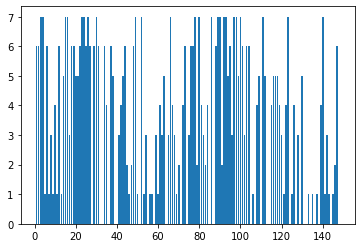

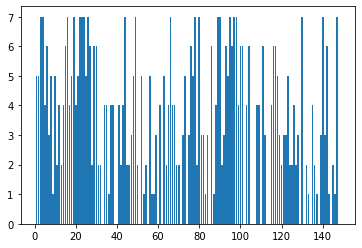

In [13]:
from torch_geometric.data import DataLoader



cnt_dict = []
cnt_dict.append({i+1:0 for i in range(148)})
cnt_dict.append({i+1:0 for i in range(148)})

for tc,d  in enumerate(DataLoader(model.dataset['test'], batch_size = 1)):
        
    
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

    #if(d.y == 0) : continue
    
    print(d.y)
    node = torch.tensor(range(1,149))
    ps,ss = model.model.get_att(d)
    #print(ps[0].shape, ps[1].shape, ps[2].shape)
    len_ps = len(ps)
    #print(len_ps)
    
    print('-----node-----')
    #node = node[ps[0]]
    #node = node[ps[1]]
    #node = node[ps[2]]
    for i in range(len_ps):
        node = node[ps[i]]
        print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
        print(ps[i])
        print(ss[i])
        
    
    print(node)
    #print(ss[-1])
    #print(ss[-2])
    
    
    print(node[(ss[-1]>0.5)])
    for v in node[(ss[-1]>0.5)].tolist():
        cnt_dict[d.y][v] =  cnt_dict[d.y][v] + 1
    
    
    #if(tc >= 5): break
plt.figure(0)
print(dict(filter(lambda elem:elem[1]>=5, cnt_dict[0].items())).keys())
plt.bar(cnt_dict[0].keys(),cnt_dict[0].values())


plt.figure(1)
print(dict(filter(lambda elem:elem[1]>=6, cnt_dict[1].items())).keys())
plt.bar(cnt_dict[1].keys(),cnt_dict[1].values())



In [32]:
[ss_.shape for ss_ in ss]

[torch.Size([119]), torch.Size([96]), torch.Size([77])]

In [90]:
node = torch.tensor(range(148))
no

In [78]:

[ 6,  2,  8, 22, 18, 13,  9, 23, 11,  7,  5, 12]
[35, 20, 77, 19,  0, 15, 50, 26,  5, 17, 81, 28, 22, 24, 75,  9, 69, 36,
        11, 14, 16, 79, 47, 56,  6, 52, 94,  8,  1,  7, 45]

[6, 2, 8, 22, 18, 13, 9, 23, 11, 7, 5, 12]